In [36]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functions.csv_max_minshift import get_folder,load_voltages_hdf5,load_params,load_voltages_csv
import os
from functions.savedata import saveplot
import json

c:\Users\Pc\Documents\Charite\NEURON\Extracellular_test\HH_simple\data\1\cfreq\2000Hz
c:\Users\Pc\Documents\Charite\NEURON\Extracellular_test\HH_simple\data\1\cfreq\2000Hz\200Vm
c:\Users\Pc\Documents\Charite\NEURON\Extracellular_test\HH_simple\data\1\cfreq\2000Hz
c:\Users\Pc\Documents\Charite\NEURON\Extracellular_test\HH_simple\data\1\cfreq\2000Hz\200Vm
maxpseg=Fast Spiking[0].dend(0.987179)
maxnseg=Fast Spiking[0].dend(0.987179)
Low pass filter of order:6 and with a cutoff:100 applied to the data successfully
Low pass filter of order:6 and with a cutoff:100 applied to the data successfully
Filtered maxpvoltages: [-69.99986233 -69.99986235 -69.99986238 -69.99986241 -69.99986244
 -69.99986247 -69.9998625  -69.99986252 -69.99986255 -69.99986258]
Low pass filter of order:6 and with a cutoff:100 applied to the data successfully
Low pass filter of order:6 and with a cutoff:100 applied to the data successfully


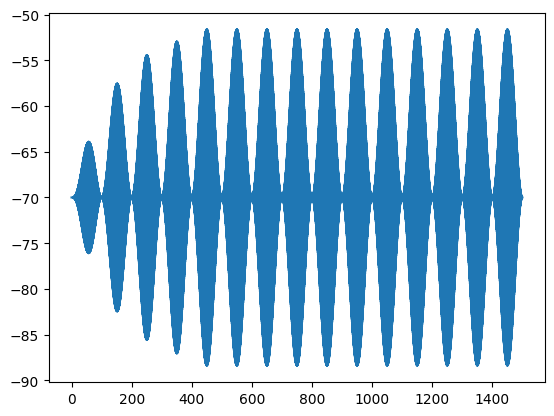

In [37]:
from functions.low_pass import filter_data,plot_onlyfiltered,butter_bandpass_filter
from functions.csv_max_minshift import get_folder,cmax_shift,plot_show
order=3
CF=2000
E=200
dt=0.001
cell_id=1
data_dir=os.getcwd()

var="cfreq"
filtered=False
freq_dir,e_dir,param_dir=get_folder(CF,E,cell_id,var,filtered=filtered,data_dir=data_dir)

max_shift, max_v, min_v, results=cmax_shift(e_dir,freq_dir,param_dir,var)
maxpvoltages,maxnvoltages,filtered_maxp,filtered_maxn,filtered_file,t=filter_data(CF,E,cell_id,cutoff=100,results=results,var=var,order=order,save=False,plot=False)
plt.plot(t,maxpvoltages)

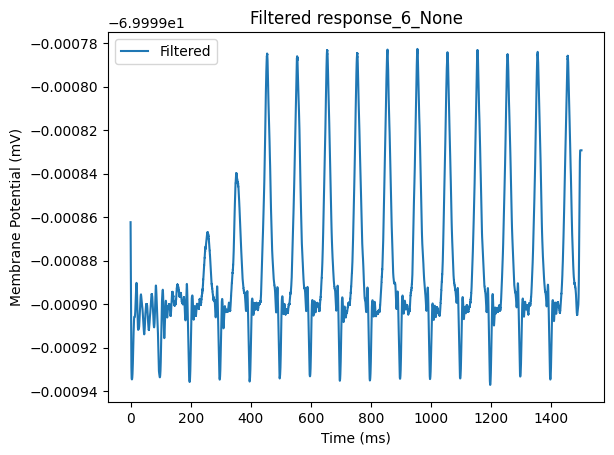

In [38]:
plot_onlyfiltered(t,filtered_maxp,title=None,file=None,order=order)


In [5]:
#Test data
def make_fake_data(dt=0.001, simtime=1500, noise_level=0.5,cfreq=20000,modfreq=10):
        
    """
    Generate fake membrane potential data for debugging.

    Parameters:
        dt (float): Time step in milliseconds.
        simtime (float): Total simulation time in milliseconds.
        noise_level (float): Amplitude of random noise to add to the signal.

    Returns:
        voltages (pd.DataFrame): Time and fake voltage data.
    """

    # Time vector: start=0, stop=simtime, step=dt
    t = np.arange(0, simtime, dt)
    
    # Simulated signal: a combination of sine waves + noise
    f1 = cfreq  # Frequency of the main signal (Hz)
    f2 =  modfreq # Secondary frequency
    signal = -65 + 10 * np.sin(2 * np.pi * f1 * t / 1000) + 2 * np.sin(2 * np.pi * f2 * t / 1000)
    
    # Add random noise
    noise = np.random.normal(0, noise_level, size=len(t))
    voltages = signal + noise
    return voltages,t

   

In [6]:
from scipy.signal import butter, filtfilt,freqz,hilbert,lfilter,sosfilt
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyquist=0.5*fs
    low = lowcut / nyquist
    high = highcut / nyquist
    # Ensure frequencies are valid
    if not (0 < low < 1 and 0 < high < 1):
        raise ValueError(f"Cutoff frequencies must be within (0, Nyquist). Got low={lowcut}, high={highcut}, fs={fs}.")
    
    b,a = butter(order, [low, high], btype='band', analog=False)
    return b,a
    
def butter_bandpass_filter(signal, dt, modfreq=10,lowcut=None, highcut=None,order=3):
    fs=1/(dt/1000) #Hz
    
    if lowcut is None:
        lowcut=0.7*modfreq
    if highcut is None:
        highcut = 1.3 * modfreq
    
    b,a = butter_bandpass(lowcut, highcut, fs, order)

   # Add padding
    pad_len = len(signal) // 5
    padded_signal = np.pad(signal, (pad_len, pad_len), mode="reflect")

    # Apply SOS filter
    # filtered = sosfilt(sos, padded_signal)
    
    filtered = lfilter(b, a, padded_signal)
    # filtered = filtfilt(b, a, signal)
    return filtered[pad_len:-pad_len]

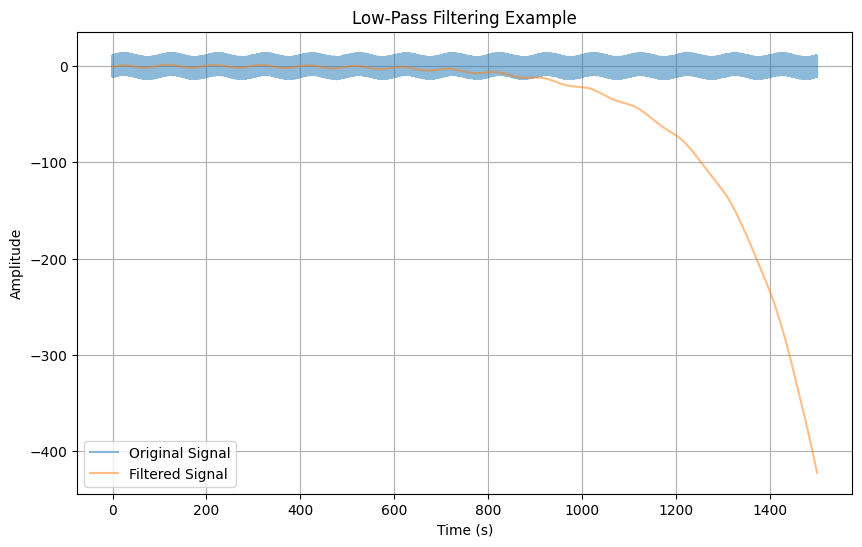

In [7]:
from tqdm import tqdm
highcut=100
lowcut=5
voltages,time=make_fake_data(dt, simtime=1500, noise_level=0.5,cfreq=20000,modfreq=10)
signal=voltages-np.mean(voltages)
dt=dt
modfreq=10
order=2
filtered_data=butter_bandpass_filter(signal, dt, modfreq=modfreq,lowcut=lowcut, highcut=highcut,order=order)

# for i in tqdm(filtered_data):
#     print(i)

# print(filtered_data)
# Plot the original and filtered data
plt.figure(figsize=(10, 6))
plt.plot(t, signal, alpha=0.5,label='Original Signal')
plt.plot(t, filtered_data, alpha=0.5, label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Low-Pass Filtering Example')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import functions.ft_analysis as ft
fourier=ft.Fourier(signal,dt)
fig=fourier.plot_spectrum(interactive=True,max_freq=2100)


In [9]:
fourier2=ft.Fourier(filtered_data,dt)
fig2=fourier2.plot_spectrum(interactive=True,max_freq=2100)


[-1.65199940e+187 -1.65447436e+187 -1.65695304e+187 ...              nan
              nan              nan]


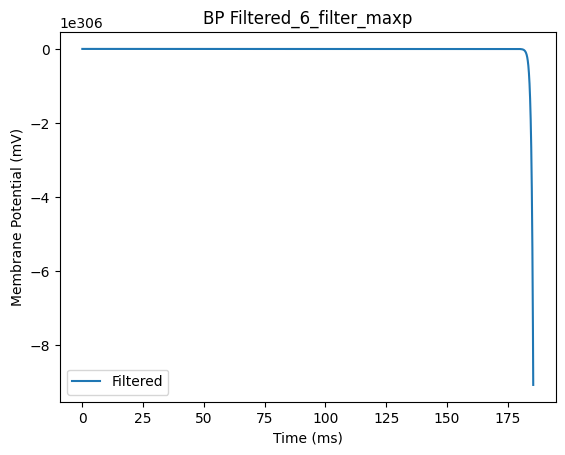

In [26]:

voltages=np.array(maxpvoltages)
signal=voltages-np.mean(voltages)
dt=dt
modfreq=10
order=3

filtered=butter_bandpass_filter(signal, dt, modfreq=modfreq,lowcut=lowcut, highcut=highcut,order=order)
print(filtered)
plot_onlyfiltered(t,filtered,order=3,info="filter_maxp",save=False,file=filtered_file,bp=True)


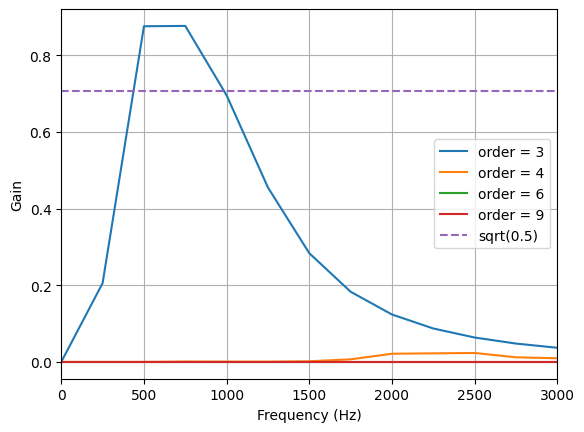

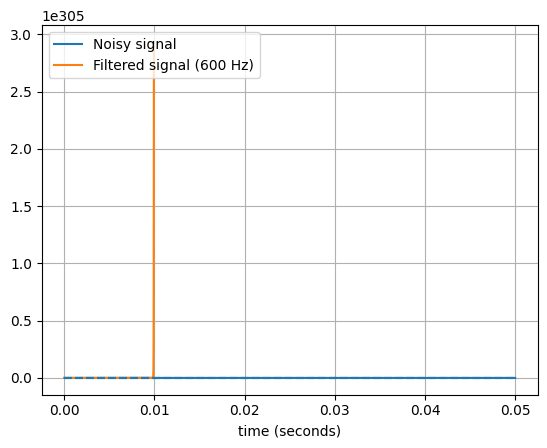

In [10]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def run():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 1/(0.001/1000)
    # fs=5000
    lowcut = 1
    highcut = 1000

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3,4, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
         # Convert from rad/sample to Hz
        freqs = w * fs / (2 * np.pi)

        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')
    plt.xlim(0,3000) 
    # Filter a noisy signal.
    T = 0.05
    nsamples = int(T * fs)
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 600.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()


run()

In [11]:
def butter_lowpass_filter(data, cutoff, fs,order):
    """
    Applies a low-pass Butterworth filter.

    Parameters:
        data (array): The input signal.
        cutoff (float): The cutoff frequency of the filter (Hz).
        fs (float): The sampling frequency (Hz).
        order (int): The order of the filter.

    Returns:
        filtered_data (array): The filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalized cutoff frequency
    # Design the Butterworth filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Apply the filter using filtfilt (zero-phase filtering)
    filtered_data = filtfilt(b, a, data)
    print(f"Low pass filter of order:{order} and with a cutoff:{cutoff} applied to the data successfully")
    return filtered_data


def butter_highpass_filter(data,lowcut,fs,order):
    """
    Applies a high-pass Butterworth filter.

    Parameters:
        data (array): The input signal.
        cutoff (float): The cutoff frequency of the filter (Hz).
        fs (float): The sampling frequency (Hz).
        order (int): The order of the filter.

    Returns:
        filtered_data (array): The filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = lowcut / nyquist  # Normalized cutoff frequency
    # Design the Butterworth filter
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    # Apply the filter using filtfilt (zero-phase filtering)
    filtered_data = filtfilt(b, a, data)
    print(f"Highpass filter of order:{order} and with a cutoff:{lowcut} applied to the data successfully")
    return filtered_data

Bode plot created for a 2-order Band-Pass Butterworth filter with HF 1000 Hz and LF 5 Hz.


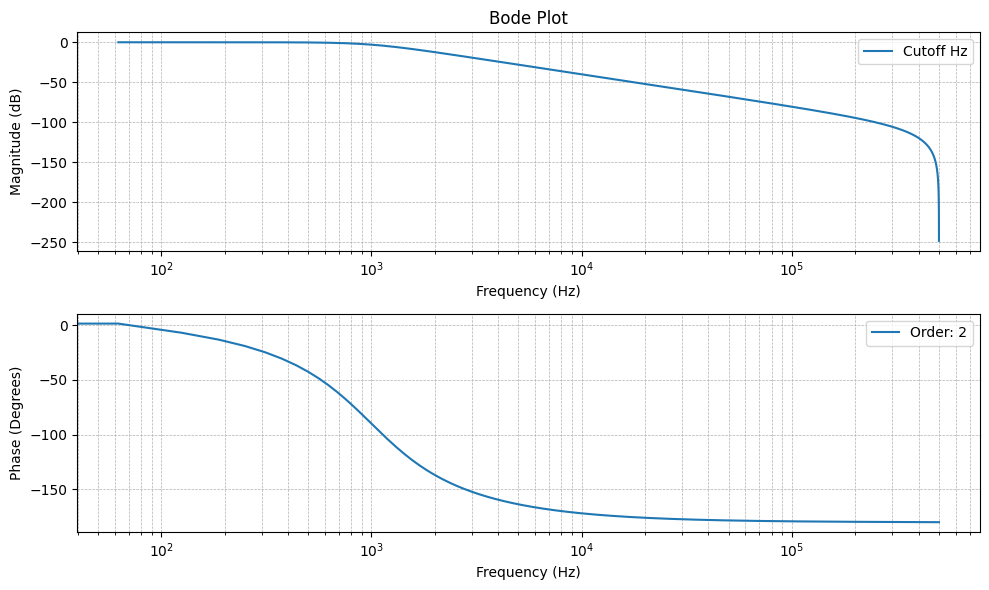

In [42]:
from functions.low_pass import plot_bode_bandpass
fs=1/(0.001/1000)
plot_bode_bandpass(lowcut=5,highcut=1000, fs=fs, order=1,save_dir=None,save=False)

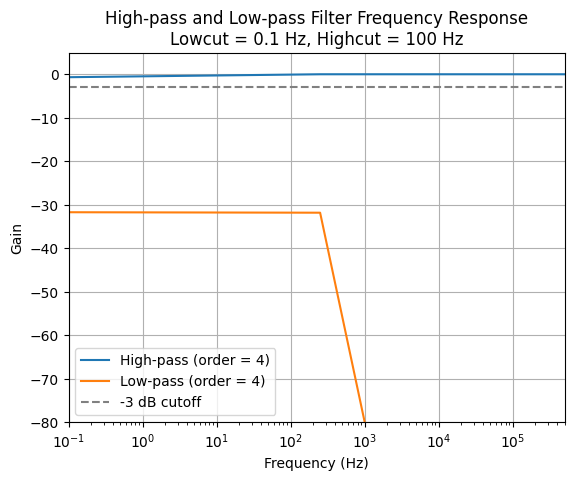

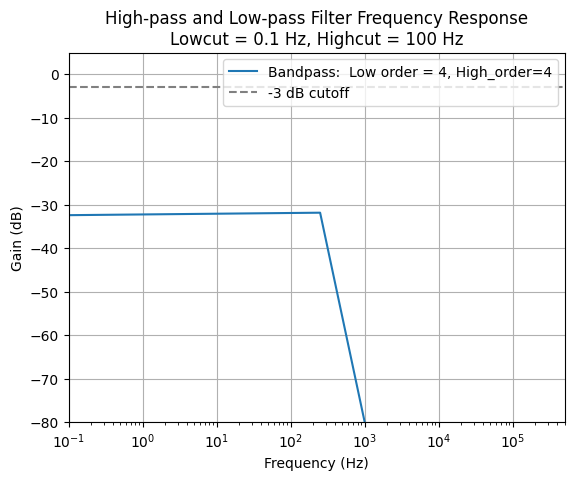

In [46]:
from functions.low_pass import plot_bode_both,plot_bode_together,low_and_high_pass
dt=0.001
fs=1/(dt/1000)
lowcut=0.1
highcut=100
order_high=2
order_low=2
plot_bode_both(fs,lowcut,highcut,freqlim=None,save_dir=None,save=False,order_high=order_high,order_low=order_low)
plot_bode_together(fs,lowcut,highcut,freqlim=None,save_dir=None,save=False,order_high=order_high,order_low=order_low)

Low pass filter of order:4 and with a cutoff:100 applied to the data successfully
Highpass filter of order:4 and with a cutoff:0.1 applied to the data successfully


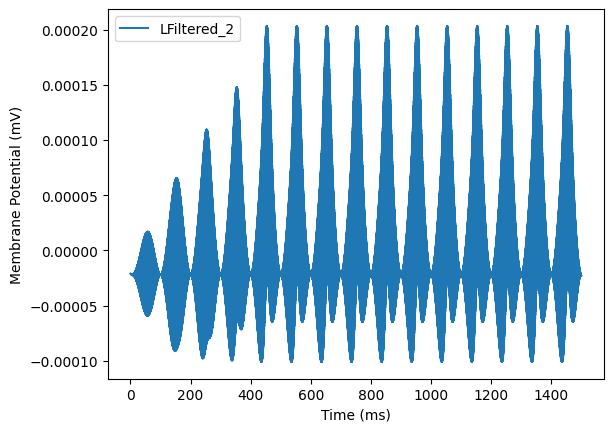

In [48]:
lpfiltered,hpfiltered=low_and_high_pass(maxpvoltages-np.mean(maxpvoltages),dt,lowcut,highcut,order_low=order_low,order_high=order_high)


fig,ax=plt.subplots()
ax.plot(t,lpfiltered,label=f"LFiltered_{order_low}")
# ax.plot(t,hpfiltered,label=f"BPFiltered_{order_high}",alpha=0.5)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Membrane Potential (mV)")
ax.legend()
plt.show()

Low pass filter of order:6 and with a cutoff:100 applied to the data successfully


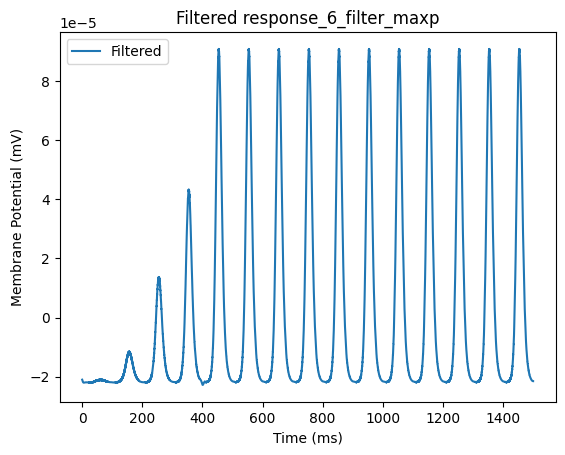

In [54]:
from functions.low_pass import butter_lowpass_filter
voltages=maxpvoltages-np.mean(maxpvoltages)
cutoff=100
dt=0.001
fs=1/(dt/1000)
order=3
filtered=butter_lowpass_filter(voltages, cutoff, fs,order)

plot_onlyfiltered(t,filtered,order=order,info="filter_maxp",save=False,file=None,bp=False)


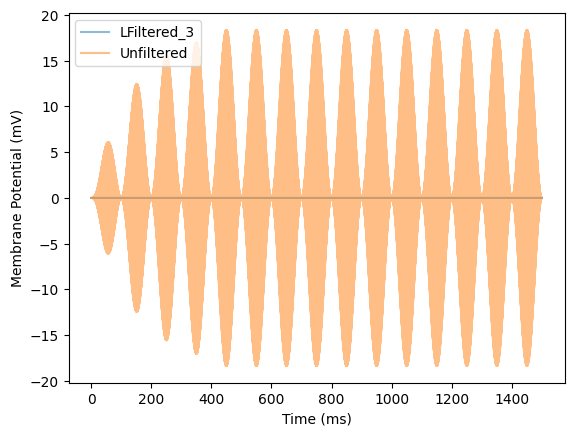

In [50]:
fig,ax=plt.subplots()
ax.plot(t,filtered,label=f"LFiltered_{order}",alpha=0.5)
ax.plot(t,voltages,label=f"Unfiltered",alpha=0.5)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Membrane Potential (mV)")
ax.legend()
plt.show()

In [51]:
import functions.ft_analysis as ft
fourier=ft.Fourier(filtered,dt)
fig=fourier.plot_spectrum(interactive=True,max_freq=2100)

In [52]:
import functions.ft_analysis as ft
fourier=ft.Fourier(voltages,dt)
fig=fourier.plot_spectrum(interactive=True,max_freq=2100)